# Overview

This analysis is using my personal listneing history from July 5, 2020 to December 5, 2020. Data was retreieved by connecting my spotify account to lastfm to be able to track everything I listen to. I then used pylast, and the spotify API to generate the dataframe being used in this analysis.

# Import Libraries

In [ ]:
import pandas as pd
from datetime import datetime
import pytz
import plotly.express as px
import plotly.figure_factory as ff
import numpy as np

# Define Functions

In [2]:
def create_histogram(df, col):
    new_df = df.dropna()
    fig = px.histogram(df, x=col)
    fig.show("png")
    
def create_distplot(df, col):
    new_df = df.dropna()
    hist_data = [new_df[col].tolist()]
    group_labels = ["{0}_label".format(col)]

    fig = ff.create_distplot(hist_data, group_labels)
    fig.show("png")

# Read in the data from csv file

In [134]:
listening_history_df = pd.read_csv("track_logs.csv")

In [135]:
# Need to format the data to be able to extract the month and year properly 
local_format = "%d %b %Y, %H:%M"
gmt = pytz.timezone("GMT")
eastern = pytz.timezone("US/Eastern")

listening_history_df["playback_date_new"] = [datetime.strptime(val, local_format) for val in listening_history_df["playback_date"]]
listening_history_df["eastern_time"] = [gmt.localize(val).astimezone(eastern) for val in listening_history_df["playback_date_new"]]
listening_history_df["month"] = [val.month for val in listening_history_df["eastern_time"]]
listening_history_df["year"] = [int(val.split("-")[0]) for val in listening_history_df["release_date"]]

### Top Tracks
As you can see, there is stark contrast in the music that I listen to :) 

In [146]:
listening_history_df["title"].value_counts().reset_index().head(n=10)

,index,title
0,Laugh Now Cry Later (feat. Lil Durk),50
1,Woodlawn,45
2,Plastic Love,38
3,I Want You Around,38
4,Build My Life,37
5,All I Need (with Mahalia & Ty Dolla $ign),34
6,Where Were You in the Morning?,31
7,Chicago Freestyle (feat. Giveon),31
8,Dynamite,30
9,Dragonball Durag,30


### Top Artists
Ah yes, Drake as the top spot once again. It has been Drake for the last 3 years or so, gotta stay loyal to my guy from the 6ix.

In [147]:
listening_history_df["artist"].value_counts().reset_index().head(n=10)

,index,artist
0,Drake,246
1,Kanye West,184
2,Frank Ocean,171
3,Hillsong Worship,170
4,Shawn Mendes,155
5,Housefires,147
6,Aminé,109
7,Elevation Worship,103
8,Jaden,93
9,BTS,90


### Exploring genre data
To properly look at the genre data we first need to format them. They show up as a single column that looks something like ['hip hop', 'pop']. I had to parse every unique genre out and then see which ones showed up for every track.

In [103]:
genre_cleanup_df = listening_history_df[["artist","genres"]].drop_duplicates().dropna()
genres = list(set(genre_cleanup_df["genres"]))

In [104]:
cleaned_genres = [
    (((val
             .replace("'","")) # Get rid of '
            .replace("[","")) # Get rid of [
        .replace("]","")) # Get rid of ]
    .split(", ") # Turn the string into a list
    
    for val in genres if val != "[]"
]

# Getting a list of the unique genres
final_genre_list =  list(set(sum(cleaned_genres, [])))

In [105]:
for val in final_genre_list:
    genre_cleanup_df[val] = np.nan
    new_list = []
    for elem in genre_cleanup_df["genres"]:
        if val in elem:
            new_list.append(1)
        else:
            new_list.append(0)
    genre_cleanup_df[val] = new_list

In [106]:
genre_counts = genre_cleanup_df[final_genre_list].sum().reset_index()
genre_counts.columns = ["genre","count"]

Looking at the results for the top 15 genres, it is not too surprising. We can see pop on top as there is overlap with hip hop and rap as well 

In [118]:
hip_hop_overlap = len(genre_cleanup_df[(genre_cleanup_df["pop"] == 1) & (genre_cleanup_df["hip hop"] == 1)])
rap_overlap = len(genre_cleanup_df[(genre_cleanup_df["pop"] == 1) & (genre_cleanup_df["rap"] == 1)])
rb_overlap = len(genre_cleanup_df[(genre_cleanup_df["pop"] == 1) & (genre_cleanup_df["r&b"] == 1)])

print("There are {0} pop songs that overlap with hip hop".format(hip_hop_overlap))
print("There are {0} pop songs that overlap with rap".format(rap_overlap))
print("There are {0} pop songs that overlap with r&b".format(rb_overlap))

There are 114 pop songs that overlap with hip hop
There are 166 pop songs that overlap with rap
There are 149 pop songs that overlap with r&b


In [107]:
genre_counts.sort_values("count",ascending=0).head(n=15)

,genre,count
660,pop,572
140,hip hop,367
225,rap,350
316,r&b,347
520,soul,271
619,alternative r&b,166
223,rock,155
588,trap,151
490,christian,134
442,dance pop,130


In [121]:
unique_genres = len(final_genre_list)
print("There are {0} unqiue genres that you listen to".format(unique_genres))

There are 672 unqiue genres that you listen to


Something interesting is how many regional sub genres there are. Some examples below include the pop and hip hop genres. I had no idea there were this many sub genres and I had no idea I listened to irish hip hop :shrug:

In [145]:
pop_sub_genres = [val for val in final_genre_list if "pop" in val]
print("There are {0} pop sub-genres\n".format(len(pop_sub_genres)))
print(pop_sub_genres)

There are 100 pop sub-genres

['alternative pop rock', 'pop urbaine', 'gauze pop', 'vapor pop', 'acoustic pop', 'indie pop rap', 'bubblegum pop', 'modern alternative pop', 'pop rock', 'baroque pop', 'swedish indie pop', 'chinese electropop', 'art pop', 'indie electropop', 'etherpop', 'swedish electropop', 'k-pop', 'korean pop', 'malaysian pop', 'classic country pop', 'canadian pop', 'chamber pop', 'scandipop', 'psychedelic pop', 'social media pop', 'christian pop', 'indie cafe pop', 'pop rap', 'pop r&b', 'popping', 'dream pop', 'colombian pop', 'channel pop', 'latin pop', 'hip pop', 'dutch pop', 'j-pop', 'shimmer pop', 'pop emo', 'bedroom pop', 'icelandic pop', 'ghanaian pop', 'neon pop punk', 'nyc pop', 'shiver pop', 'soda pop', 'polynesian pop', 'barbadian pop', 'swedish synthpop', 'new wave pop', 'brill building pop', 'electropop', 'modern dream pop', 'chill pop', 'indie dream pop', 'bow pop', 'afropop', 'pop punk', 'pop dance', 'dance pop', 'sophisti-pop', 'nz pop', 'pop edm', 'exp

In [144]:
hip_hop_sub_genres = [val for val in final_genre_list if "hip hop" in val]
print("There are {0} hip hop sub-genres\n".format(len(hip_hop_sub_genres)))
print(hip_hop_sub_genres)

There are 57 hip hop sub-genres

['east coast hip hop', 'boston hip hop', 'buffalo hip hop', 'portland hip hop', 'industrial hip hop', 'nigerian hip hop', 'irish hip hop', 'brazilian hip hop', 'australian hip hop', 'miami hip hop', 'uk alternative hip hop', 'psychedelic hip hop', 'hip hop', 'atl hip hop', 'southern hip hop', 'kentucky hip hop', 'zambian hip hop', 'christian hip hop', 'underground hip hop', 'deep underground hip hop', 'south african hip hop', 'hardcore hip hop', 'french hip hop', 'manchester hip hop', 'ohio hip hop', 'old school hip hop', 'indonesian hip hop', 'virginia hip hop', 'political hip hop', 'canadian hip hop', 'queens hip hop', 'lgbtq+ hip hop', 'experimental hip hop', 'tennessee hip hop', 'memphis hip hop', 'nashville hip hop', 'belgian hip hop', 'milwaukee hip hop', 'winnipeg hip hop', 'arkansas hip hop', 'birmingham hip hop', 'alternative hip hop', 'indiana hip hop', 'harlem hip hop', 'indie hip hop', 'hawaiian hip hop', 'asian american hip hop', 'conscious

### Top tracks by month
Yes I had a Shawn Mendes phase.

In [ ]:
monthly_count = listening_history_df.groupby(["month","title"]).size().reset_index()
monthly_count.columns = ["month","title","count"]

In [8]:
monthly_count.groupby("month").apply(lambda x: x.nlargest(1, "count")).reset_index(drop=True)

,month,title,count
0,7,Chicago Freestyle (feat. Giveon),6
1,8,Anthem // Great Are You Lord - Live,19
2,9,Slide (feat. Frank Ocean & Migos),10
3,10,Where Were You in the Morning?,22
4,11,Time Flies,14
5,12,Wonder,4


### Top Tracks by Day of Week
0 = Monday, 6 = Sunday. Jesus on Sundays and Drake during the week.

In [ ]:
weekday_count = listening_history_df.groupby(["weekday","title"]).size().reset_index()
weekday_count.columns = ["weekday","title","count"]

In [9]:
weekday_count.groupby("weekday").apply(lambda x: x.nlargest(1, "count")).reset_index(drop=True)

,weekday,title,count
0,0,Time Flies,14
1,1,Laugh Now Cry Later (feat. Lil Durk),9
2,2,Build My Life,12
3,3,Saved,8
4,4,All I Need (with Mahalia & Ty Dolla $ign),8
5,5,Goodness Of God (Live),11
6,6,Cornerstone - Live,8


### Top Tracks by Release Date
Here you can see that I am biased to listen to recent music. I always want to try and find the newest bop to stay relevant you know. Although I am a sucker for my 2000's

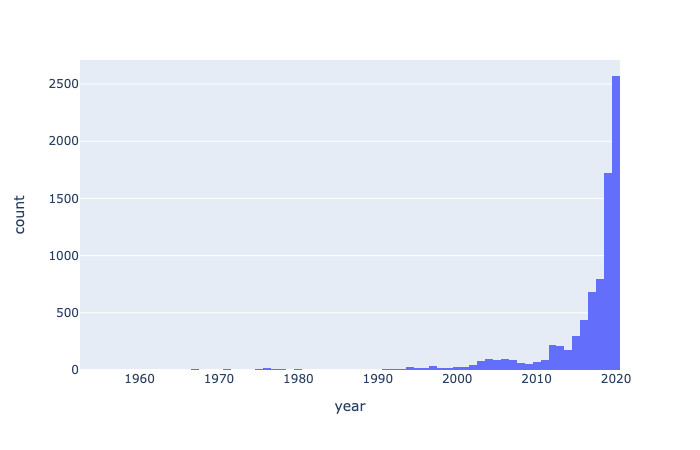

In [153]:
create_histogram(listening_history_df, "year")

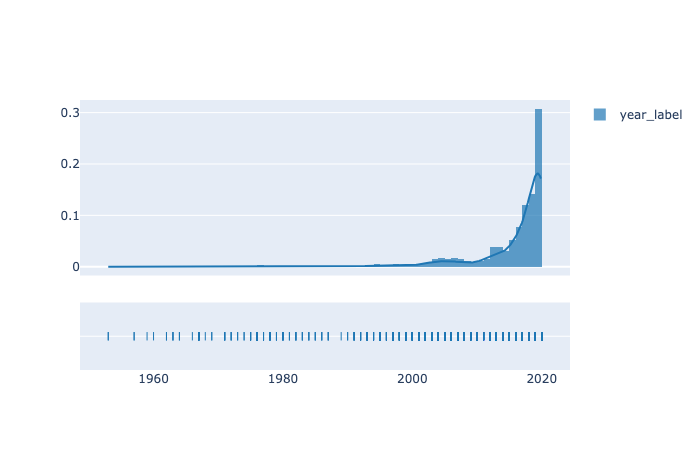

In [154]:
create_distplot(listening_history_df, "year")

In [148]:
yearly_count = listening_history_df.groupby(["year","title"]).size().reset_index()
yearly_count.columns = ["year","title","count"]

In [152]:
yearly_count.groupby("year").apply(lambda x: x.nlargest(1, "count")).reset_index(drop=True).sort_values('year',ascending=0).head(n=20)

,year,title,count
59,2020,Laugh Now Cry Later (feat. Lil Durk),50
58,2019,I Want You Around,38
57,2018,Plastic Love,38
56,2017,Slide (feat. Frank Ocean & Migos),26
55,2016,Build My Life,37
54,2015,C U Girl,16
53,2014,Aleluia,20
52,2013,Called Me Higher - Live,17
51,2012,Cornerstone - Live,21
50,2011,Novacane,4


### Distribution of Tracks by popularity
For the most part I am listening to popular music. Somewhat basic I guess

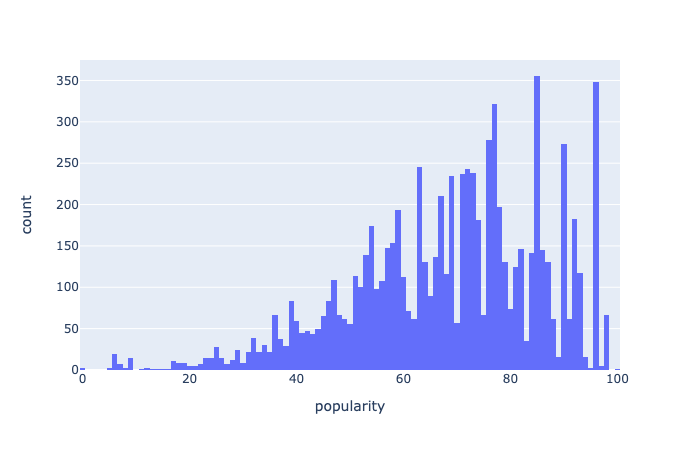

In [12]:
create_histogram(listening_history_df, "popularity")

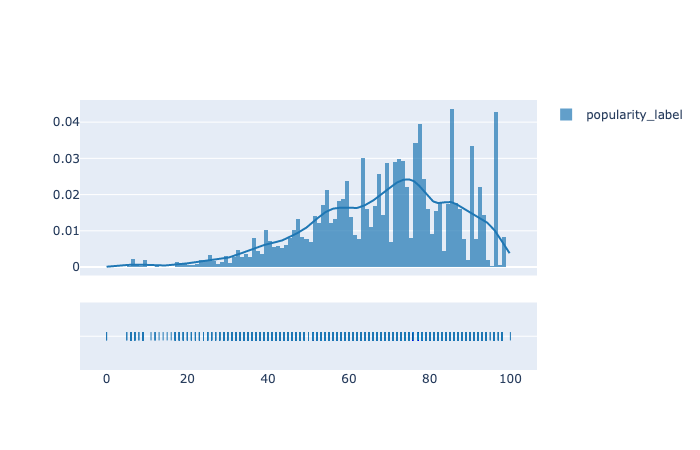

In [13]:
create_distplot(listening_history_df, "popularity")